In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


# Hermes IO

In [4]:
casestore = dict()

In [5]:
db = CaseDB()

toload = [
    dict(name="1e19", id="d10d-anom_visc", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="2e19", id="d11b-d10d_2e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="3e19", id="d11c-d10d_3e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True)
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]


In [6]:
plt.close("all")
%matplotlib inline

In [9]:
write_file(casestore, r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl written


## Read Hermes data

In [7]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

1e19
2e19


# Read SOLEDGE CSV data

In [2]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



In [24]:
path = soledgecases["nocore_d"]
sl["nocore_d"].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

# Read SOLPS

In [9]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

## Plots

## Lineplots

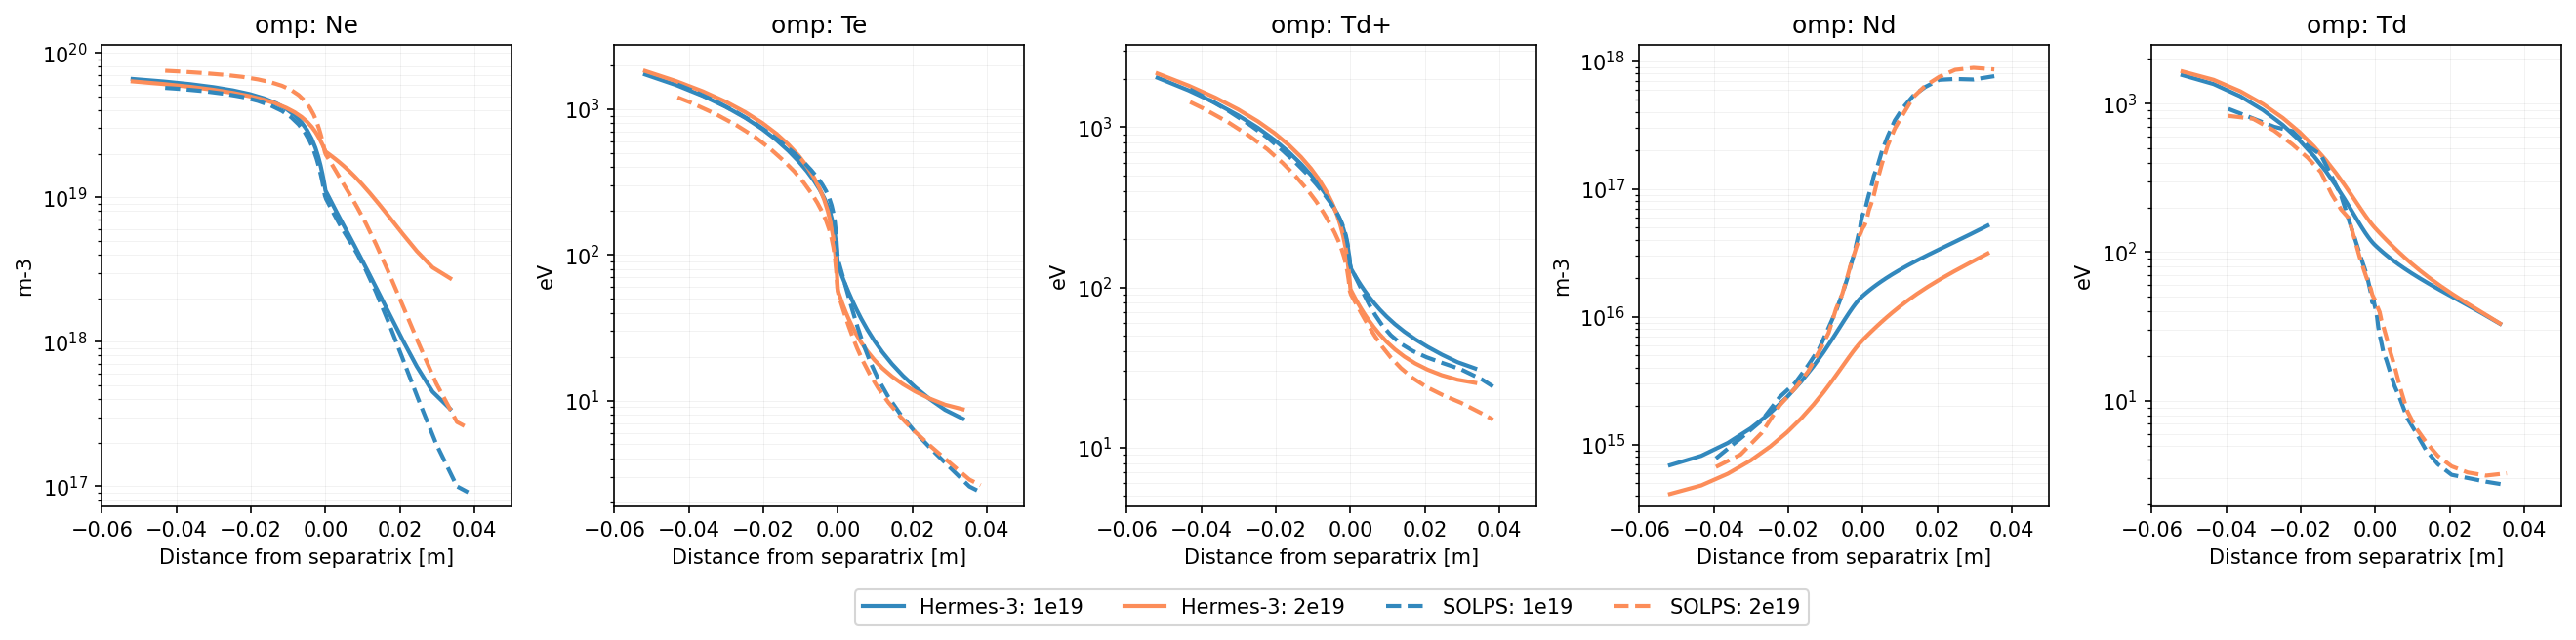

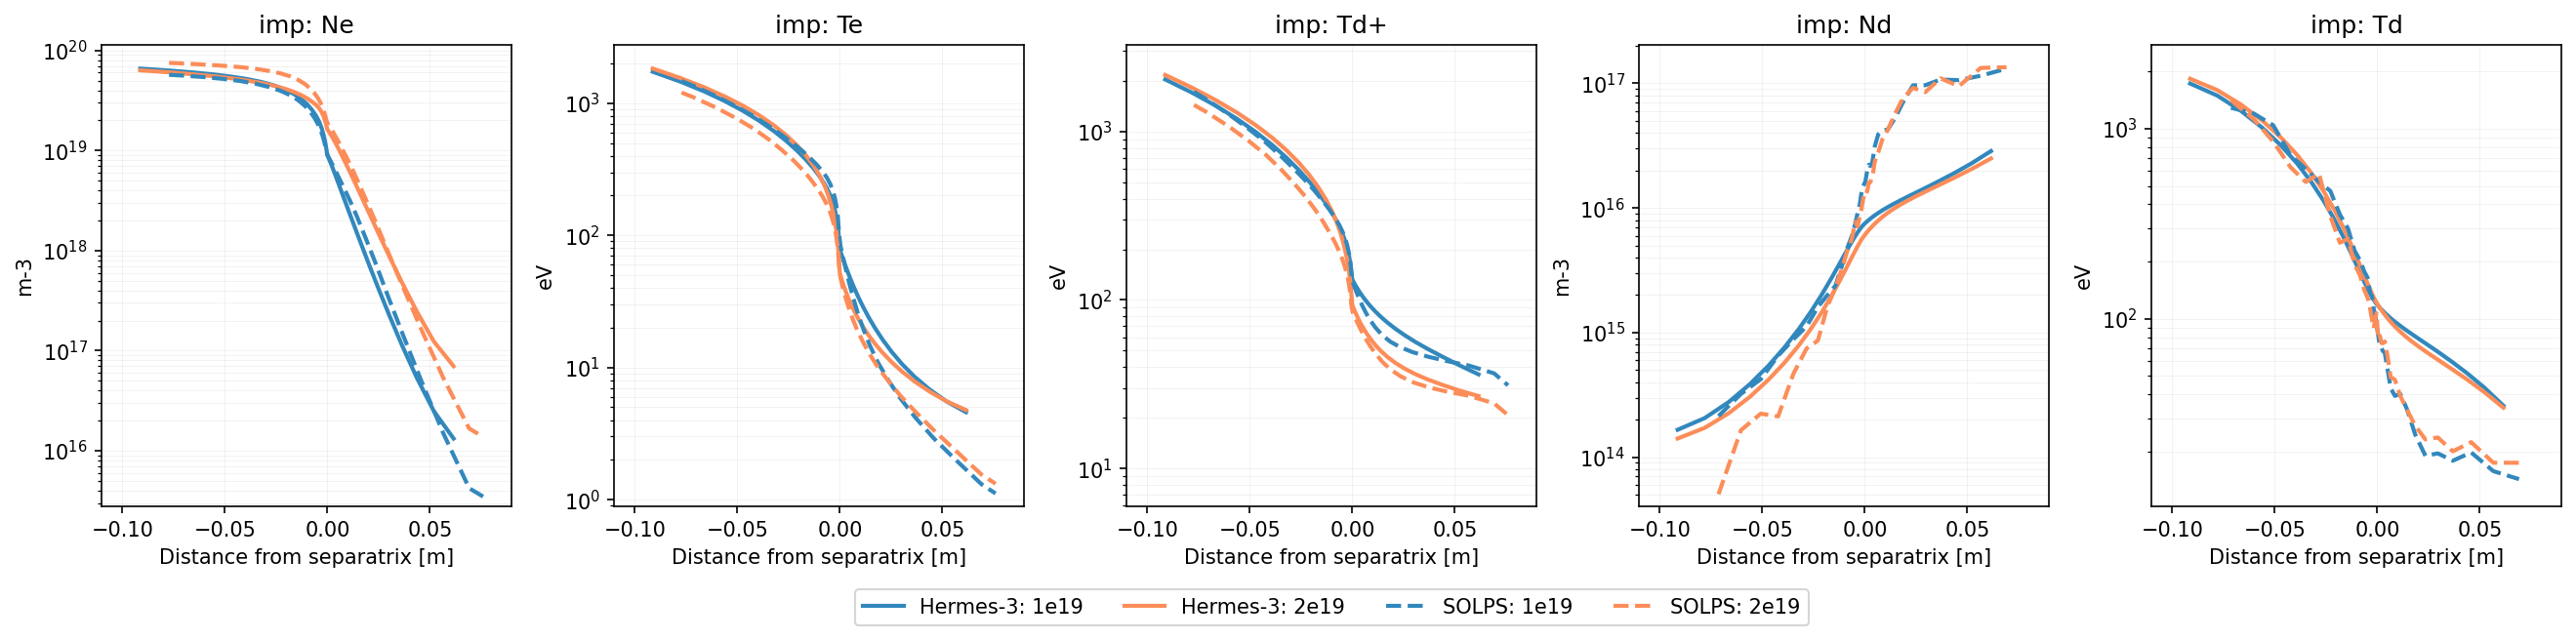

In [42]:

plt.close("all")
lineplot_compare(
    cases = { 
             
    "Hermes-3: 1e19": dict(data=hr["1e19"], color="#3288bd"),
    "Hermes-3: 2e19": dict(data=hr["2e19"], color="#fc8d59"),
    # "Hermes-3: 3e19": dict(data=hr["3e19"], color="#fc8d59"),
    
    "SOLPS: 1e19" : dict(data=sp["no_visc"], color="#3288bd"),
    "SOLPS: 2e19" : dict(data=sp["nsep_2e19"], color="#fc8d59"),
    # "SOLPS: 3e19" : dict(data=sp["nsep_3e19"], color="#fc8d59"),
    
    # "Hermes-3: Tn_sol=30eV" : dict(data=hr["tn30"], color="teal"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03_nonsepfit"], color="darkorange"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03"], color="darkorange"),
    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 150,
    lw = 2
)

# Part II: More detail + SOLEDGE2D

In [3]:
from soledge.wrapper_class import *
slc = SOLEDGEcase(r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M")
# slc = SOLEDGEcase(r"C:\Users\mikek\OneDrive\Project\collab\Hermes-3 Comparison Shared\completed_runs\ST40_wallStd_bra_nocore_D_2e19")


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


### Get data

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

Text(0.5, 1.0, 'Neutral pressure')

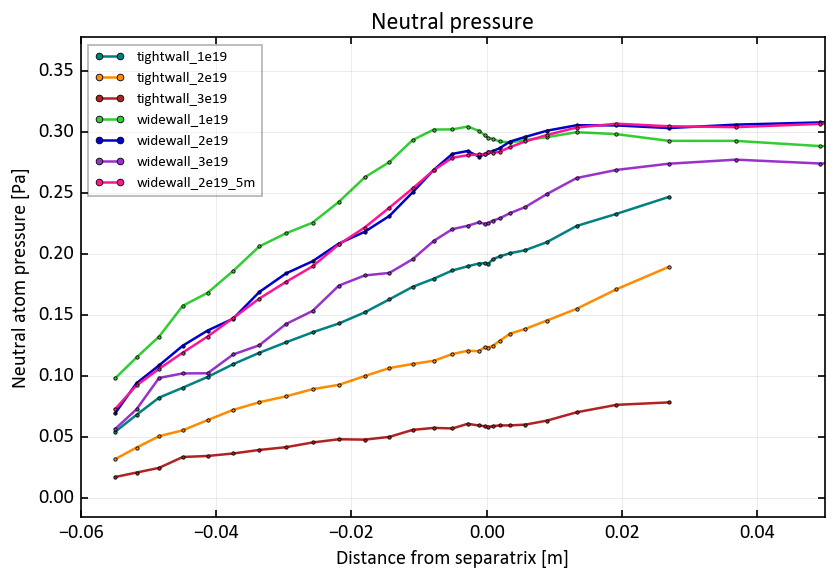

In [20]:
from soledge.wrapper_class import *
plt.style.use(r"C:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\Lib\site-packages\matplotlib\mpl-data\stylelib\mike.mplstyle")
# slc = SOLEDGEcase(r"C:\Users\mikek\OneDrive\Project\collab\Hermes-3 Comparison Shared\completed_runs\ST40_wallStd_bra_nocore_D_2e19")


dfs = []

# dist = slc.get_1d_radial_data("Dense")["dist"].values
# Ne = slc.get_1d_radial_data("Dense")["Dense"].values
# Na = slc.get_1d_radial_data("Nni")["Nni"].values
# Te = slc.get_1d_radial_data("Tempe")["Tempe"].values
# Ta = slc.get_1d_radial_data("Tni")["Tni"].values
# Vxa = slc.get_1d_radial_data("vxni")["vxni"].values
# Vya = slc.get_1d_radial_data("vyni")["vyni"].values
# Vza = slc.get_1d_radial_data("vzni")["vzni"].values
# Pa = Na * Ta * constants("q_e") * 3/2
# flux = Na * Vxa   # m-2s-1

fig, ax = plt.subplots(figsize=(8,5), dpi = 120)

for case in soledgecases:
    slc = SOLEDGEcase(soledgecases[case])
    dist = slc.get_1d_radial_data("Dense")["dist"].values
    Ta = slc.get_1d_radial_data("Tni")["Tni"].values
    Na = slc.get_1d_radial_data("Nni")["Nni"].values
    Pa = Na * Ta * constants("q_e") * 3/2
    ax.plot(dist, Pa, lw = 1.5, marker = "o", ms = 2, label = case)

ax.set_xlim(-0.06, 0.05)
ax.legend(fontsize=9)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral atom pressure [Pa]")
ax.set_title("Neutral pressure")

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

Text(0.5, 1.0, 'Radial neutral flow')

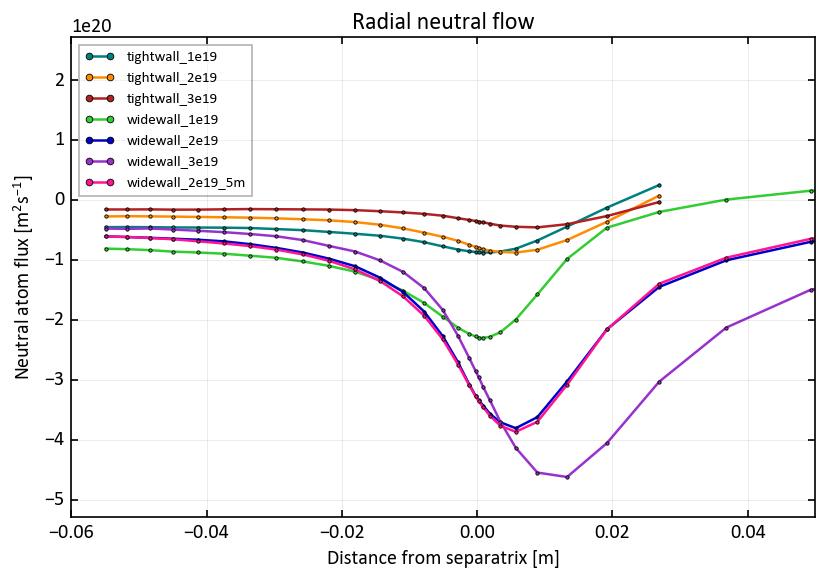

In [19]:
fig, ax = plt.subplots(figsize=(8,5), dpi = 120)

for case in soledgecases:
    slc = SOLEDGEcase(soledgecases[case])
    dist = slc.get_1d_radial_data("Dense")["dist"].values
    Vxa = slc.get_1d_radial_data("vxni")["vxni"].values
    Vya = slc.get_1d_radial_data("vyni")["vyni"].values
    Vza = slc.get_1d_radial_data("vzni")["vzni"].values
    Na = slc.get_1d_radial_data("Nni")["Nni"].values
    ax.plot(dist, Vxa * Na, lw = 1.5, marker = "o", ms = 2, label = case)

ax.set_xlim(-0.06, 0.05)
ax.legend(fontsize=9)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral atom flux $[m^{2}s^{-1}]$")
ax.set_title("Radial neutral flow")

In [17]:
soledgecases.keys()

dict_keys(['tightwall_1e19', 'tightwall_2e19', 'tightwall_3e19', 'widewall_1e19', 'widewall_2e19', 'widewall_3e19', 'widewall_2e19_5m'])

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


Text(0.5, 1.0, 'Poloidal neutral flow')

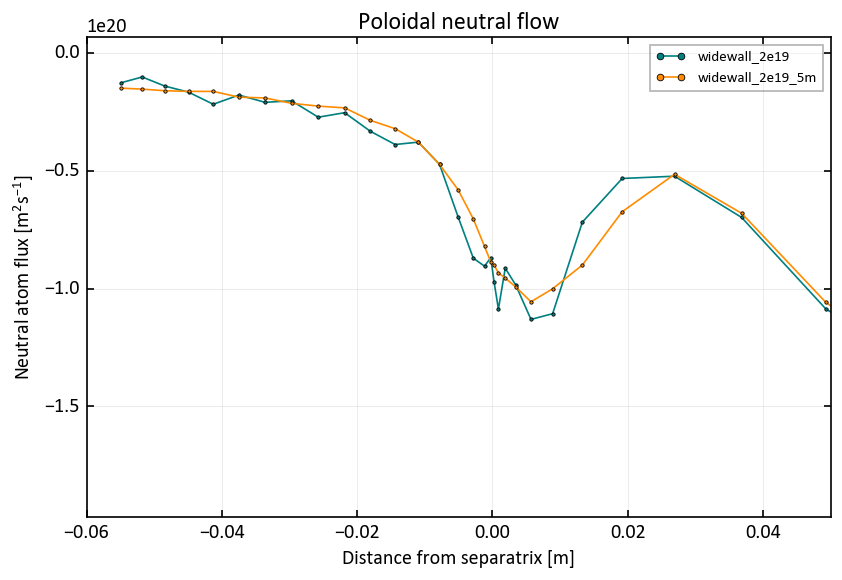

In [18]:
fig, ax = plt.subplots(figsize=(8,5), dpi = 120)

for case in ["widewall_2e19", "widewall_2e19_5m"]:
    slc = SOLEDGEcase(soledgecases[case])
    dist = slc.get_1d_radial_data("Dense")["dist"].values
    Vxa = slc.get_1d_radial_data("vxni")["vxni"].values
    Vya = slc.get_1d_radial_data("vyni")["vyni"].values
    Vza = slc.get_1d_radial_data("vzni")["vzni"].values
    Na = slc.get_1d_radial_data("Nni")["Nni"].values
    ax.plot(dist, Vya * Na, lw = 1, marker = "o", ms = 2, label = case)

ax.set_xlim(-0.06, 0.05)
ax.legend(fontsize=9)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral atom flux $[m^{2}s^{-1}]$")
ax.set_title("Poloidal neutral flow")

### Pressure gradient

In [36]:
plt.close("all")
%matplotlib inline

In [4]:
slc = SOLEDGEcase(soledgecases["widewall_2e19_5m"])
dist = slc.get_1d_radial_data("Dense")["dist"].values
Ta = slc.get_1d_radial_data("Tni")["Tni"].values
Na = slc.get_1d_radial_data("Nni")["Nni"].values
Pa = Na * Ta * constants("q_e") * 3/2

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


In [11]:
from hermes3.neutral_transport import *
neut = NeutralTransport(
    inputs = dict(
    Ta = slc.get_1d_radial_data("Tni")["Tni"].values,
    Te = slc.get_1d_radial_data("Tempe")["Tempe"].values,
    Ti = slc.get_1d_radial_data("Tempi")["Tempi"].values,
    Na = slc.get_1d_radial_data("Nni")["Nni"].values,
    )
)

In [5]:
slc.params

['Dense',
 'Tempe',
 'velocitye',
 'Me',
 'IRade',
 '(Dens*Temp^1.5)e',
 'pi_parallele',
 'Alphame',
 'Alphape',
 'Sne',
 'SGe',
 'SEe',
 'count_Zhdanov_min_ne',
 'count_clean_min_ne',
 'count_clean_min_te',
 'count_coupling_min_te',
 'IRad1e',
 'Zeff',
 'SE1e',
 'TotRad',
 'TotNRad',
 'Densi',
 'Tempi',
 'velocityi',
 'Mi',
 'IRadi',
 '(Dens*Temp^1.5)i',
 'pi_paralleli',
 'Alphami',
 'Alphapi',
 'Sni',
 'SGi',
 'SEi',
 'count_Zhdanov_min_ni',
 'count_clean_min_ni',
 'count_clean_min_ti',
 'count_coupling_min_ti',
 'IRad1i',
 'NRadi',
 'Nni',
 'Tni',
 'Pni',
 'vxni',
 'vyni',
 'vzni',
 'Nmi',
 'Tmi',
 'vxmi',
 'vymi',
 'vzmi',
 'Ntii',
 'Ppi',
 'Epi',
 'TDensi',
 'TDensei',
 'FracDensi',
 'Cimpi',
 'FraceDensi',
 'Zavei',
 'TotRadi']

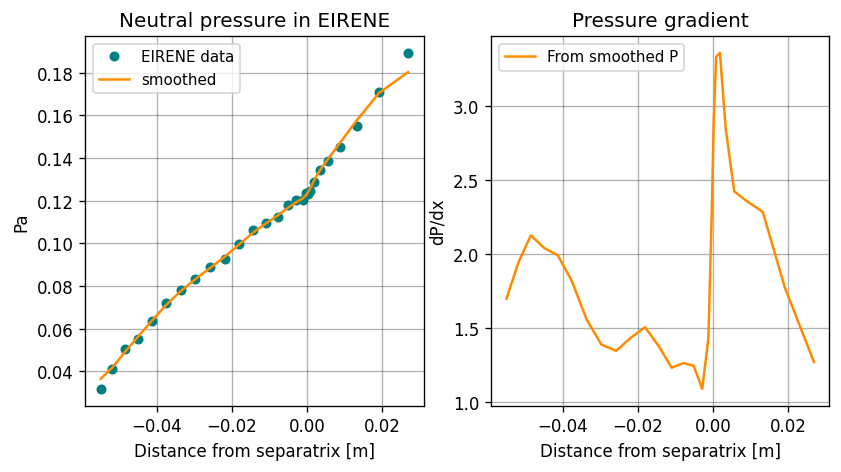

In [44]:
from sd1d.analysis import AMJUEL
rtools = AMJUEL()

def smooth(x,w,recursion=0):
    out = scipy.ndimage.gaussian_filter(x, w)
    for i in range(recursion):
        out = scipy.ndimage.gaussian_filter(out, w)
    return out

fig, axes = plt.subplots(1,2, figsize=(8,4), dpi = 120)

Pa_smooth = smooth(Pa,0.5, recursion=5)
grad_Pa = np.gradient(dist, Pa)
grad_Pa_smooth = np.gradient(Pa_smooth, dist)

axes[0].plot(dist, Pa, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[0].plot(dist, Pa_smooth, color = "darkorange", label = "smoothed")
axes[0].set_ylabel("Pa")
axes[0].set_title("Neutral pressure in EIRENE")
# axes[1].plot(dist, grad_Pa, color = "teal", label = "EIRENE raw data")
axes[1].plot(dist, grad_Pa_smooth, color = "darkorange", label = "From smoothed P")
axes[1].set_ylabel("dP/dx")
axes[1].set_title("Pressure gradient")


for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=9)
    # ax.set_xlim(None, 0.045)

In [155]:
Ne * Te 

array([8.21729129e+22, 6.69431913e+22, 5.42507403e+22, 4.39020603e+22,
       3.49384129e+22, 2.76914516e+22, 2.19861678e+22, 1.73108552e+22,
       1.35357770e+22, 1.05449600e+22, 8.19416123e+21, 6.35181142e+21,
       4.92178562e+21, 3.83939515e+21, 3.02158760e+21, 2.36686451e+21,
       1.78986444e+21, 1.21063392e+21, 1.03804203e+21, 9.50992245e+20,
       8.69363411e+20, 7.84777782e+20, 6.91265095e+20, 5.87919285e+20,
       4.78771821e+20, 3.71276137e+20, 2.73972793e+20, 1.92435470e+20,
       1.28064124e+20, 7.99108142e+19, 4.58904145e+19, 2.39717241e+19,
       1.13675438e+19, 4.90351993e+18, 1.95767040e+18, 7.95678653e+17])

In [45]:
fun = scipy.interpolate.UnivariateSpline(sdata.index, sPa)
fun(1
    )

array(nan)

# Radial flux analysis

In [58]:
def makeflux(ds):
    omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = omp["J"] * omp["g11"]
    hflux = omp["pf_perp_diff_R_d"] / area_yz
    return hflux

def makehflux(ds):
    omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = omp["J"] * omp["g11"]
    hflux = omp["hf_perp_diff_R_d"] / area_yz
    return hflux

omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

KeyError: 'pf_perp_diff_R_d'

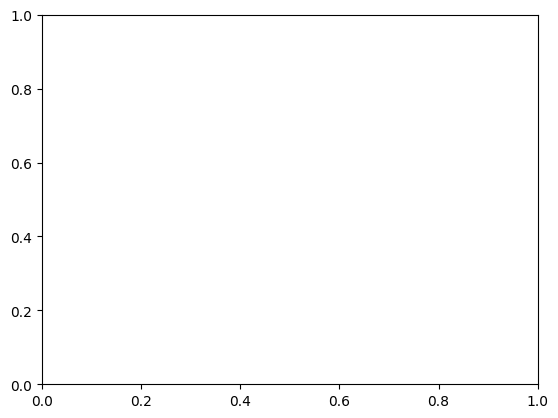

In [59]:
fig, ax = plt.subplots()
ax.plot(dist, -1*(makeflux(casestore["1e19"].ds)), label = "Hermes-3: 1e19", color = "#2b83ba", lw=2)
ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["rfluxa3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["rfluxa3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Radial neutral transport")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Radial neutral flux [m-2s-1]")

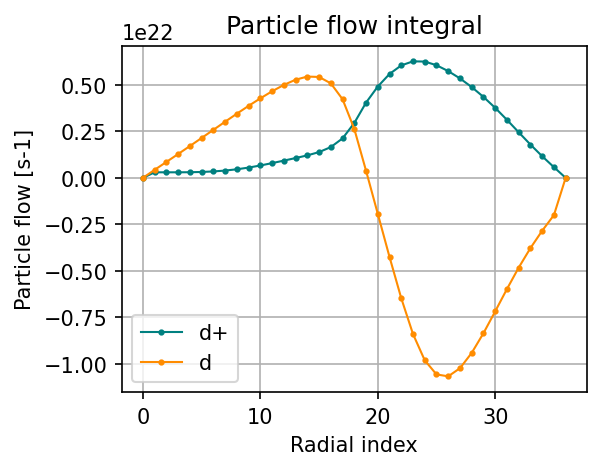

In [16]:
plot_perp_particle_fluxes(ds.isel(t=-1))